<a href="https://colab.research.google.com/github/ghazicc/ML-Project2-Regression-Analysis-and-Model-Selection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [4]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
import scipy.stats as stats

In [46]:
# print(pf.info()) #to print general info about the csv.
pf = pd.read_csv('cars.csv') #reading csv file.
pf = pf.drop('car name',axis=1)



mean_imputed = pf.copy()
# to clean dirty entries from cylinder column.

x =mean_imputed['cylinder'].unique()

for i in x:
    if isinstance(i,float) == False: #python descirdbe nan as float.
        if i.isnumeric() == False: #if the entry was string, replace it with null to replace it with the mean.
            mean_imputed.replace(i,None,inplace=True)

mean_imputed['cylinder'] = pd.to_numeric(mean_imputed['cylinder'], errors='coerce')

mean_imputed['cylinder'].fillna(mean_imputed['cylinder'].mean(), inplace=True)
pf= mean_imputed.copy()
del mean_imputed

#cylinder column now is clean.
#--------------------------------------------------------------------------------------------

#print(pf['engine_capacity'].unique()) #From this, I know that there are two types of dirty data in this column: 'cylinder' and large numbers such as 3000.
index = -1

for row in pf['engine_capacity']:
    index +=1
    if row == 'Cylinders':
        pf.loc[index,"engine_capacity"]= None
    elif i.isnumeric:
        if int(float(row)) > 20:
          pf.loc[index,"engine_capacity"]= None
        else:
          pf.loc[index,"engine_capacity"]= round(float(row),3)

pf['engine_capacity'].fillna(pf['engine_capacity'].mean(), inplace=True)



#engine capacity done.
#--------------------------------------------------------------------------------------------

#print(pf['horse_power'].unique())

index = -1
for row in pf['horse_power']:
    index+=1
    if 'Single' in row or 'Double' in row or 'Triple' in row or 'Horsepower (bhp)' in row:

        pf.loc[index,'horse_power']=None
    else:
        pf.loc[index,'horse_power']=int(row)

# pf['horse_power'].fillna(pf['horse_power'].mean(), inplace=True)



#-------------------------------------------------------------
#Now i need to check and clean topspeed and seats coloumns
#if seates is bigger than 100, transfer this value to topspeed, and put None insted of it.
# print(pf['seats'].unique())
index = -1
num=''
for row in pf['seats']:
    index +=1
    if len(row) <= 4 and row!= 'N A':
        if int(float(row)) > 60:
            pf.loc[index,"top_speed"]=int(row)
            pf.loc[index,"seats"]=None
        elif int(float(row)) < 60:
            pf.loc[index,"seats"]=None
    elif 'Seater' in row:#if it contains 'seater' that's mean that this is a real number of seats.
            num = row[:2]
            pf.loc[index,"seats"]=int(num)
    else:
        pf.loc[index,"seats"]=None

pf['seats'].fillna(pf['seats'].median(), inplace=True)

#---------------------------------------------------------------------------
#top_speed
#this column contains string, seats, and numbers.
#seats must be transfered to 'seats' coloumn.
#strings must be discarded, numbers are good!!
index = -1
for row in pf['top_speed']:
    index+=1
    if 'Seater' in str(row):
        num = row[:2]
        pf.loc[index,"seats"]=int(num)
        pf.loc[index,'top_speed']=None
    elif str(row).isnumeric() == False:
        pf.loc[index,'top_speed']=None
    else:
        pf.loc[index,'top_speed']=int(row)

# pf['top_speed'].fillna(int(pf['top_speed'].mean()), inplace=True)#221 insted of 221.22....


#hot encoding to country and brand, and normalize the price to
# print(pf['brand'].unique())
one_hot_encoded = pd.get_dummies(pf, columns=['country'])
pf = one_hot_encoded.copy()
del one_hot_encoded

# frequency-encode the brand feature, since one-hot encoding results in high dimensional sparse feature space
freq_encoding = pf['brand'].value_counts()
pf['brand'] = pf['brand'].map(freq_encoding)

topspeed_brand_mean = pf.groupby('brand')['top_speed'].transform('mean')
pf['top_speed'] = pf['top_speed'].fillna(topspeed_brand_mean) #filling each car with the mean price based on its brand.

hp_brand_mean = pf.groupby('brand')['horse_power'].transform('mean')
pf['horse_power'] = pf['horse_power'].fillna(hp_brand_mean) #filling each car with the mean price based on its brand.


#--------------------------------------------------------------------------------------------
#changing all prices to USD with cleaning and filling the dirty with the mean.

# print(len(pd.unique(pf['price']))) # i noticed from this, that i can't use replace(row,new) in the for loop, because there is just 3350 uniqe value from 6300.

#pf.loc[1,'price']='moath' #I can use this to replace the value.

#Change the prices to USD and clean the dirty entries
index =-1
for row in pf['price']:
    index+=1
    if 'SAR' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 0.27

    elif 'EGP' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 0.02

    elif 'BHD' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 2.65

    elif 'QAR' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 0.27

    elif 'OMR' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 2.6

    elif 'KWD' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 3.25

    elif 'AED' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 0.27

    else:
        pf.loc[index,"price"]=None


#fill the null values with the mean of the coloumn.
# pf['price'].fillna(pf['price'].mean(), inplace=True)


# Calculate skewness for all numerical columns
skewness = pf.select_dtypes(include=np.number).apply(stats.skew)

# Print the skewness values
print("Skewness of all numerical columns:")
print(skewness)

optional_target = pf['top_speed']

brand_mean_price = pf.groupby('brand')['price'].transform('mean')
pf['price'] = pf['price'].fillna(brand_mean_price) #filling each car with the mean price based on its brand.

#normalize the price, horsepower, and top_speed from 0 to 10
pf[['top_speed', 'horse_power', 'seats','cylinder']] = MinMaxScaler(feature_range=(0, 1)).fit_transform(pf[['top_speed', 'horse_power', 'seats','cylinder']])

# perform standardization on top speed and horse power
scaler = StandardScaler()
pf[['engine_capacity', 'brand']] = scaler.fit_transform(pf[['engine_capacity', 'brand']])

<ipython-input-46-f2234227be1b>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mean_imputed['cylinder'].fillna(mean_imputed['cylinder'].mean(), inplace=True)
<ipython-input-46-f2234227be1b>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Skewness of all numerical columns:
engine_capacity    0.731375
cylinder           1.428883
horse_power        7.118156
top_speed          2.846072
seats              1.534536
brand              0.388433
dtype: float64


<ipython-input-46-f2234227be1b>:170: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pf['price'] = pf['price'].fillna(brand_mean_price) #filling each car with the mean price based on its brand.


In [7]:
pf.describe()

,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand
count,6.308000e+03,6.308000e+03,6308.000000,6308.000000,6308.000000,6308.000000,6.308000e+03
mean,7.096518e+04,-3.153963e-16,0.184014,0.055503,0.159468,0.189739,1.126415e-17
std,1.006358e+05,1.000079e+00,0.135814,0.035425,0.053942,0.094811,1.000079e+00
min,2.880000e+03,-2.160678e+00,0.000000,0.000000,0.000000,0.000000,-1.447388e+00
25%,2.690516e+04,-6.535600e-01,0.076923,0.030965,0.118510,0.187500,-9.969977e-01
50%,4.374114e+04,-1.260686e-01,0.184014,0.048035,0.146727,0.187500,-4.685980e-02
75%,8.241812e+04,4.767786e-01,0.230769,0.070464,0.191874,0.187500,8.785992e-01
max,3.594996e+06,3.867795e+00,1.000000,1.000000,1.000000,1.000000,2.001489e+00


In [8]:
pf = pf.apply(pd.to_numeric, errors='coerce')
print(f"number of features: {len(pf.columns)}")
print(f"number of NaN values: {pf.isna().sum().sum()}")

number of features: 14
number of NaN values: 0


In [9]:
# Count non-numeric values
non_numeric_count = pf.applymap(lambda x: not pd.api.types.is_numeric_dtype(type(x))).sum().sum()

print(f"Number of non-numeric values: {non_numeric_count}")

<ipython-input-9-d1a2bb8993b4>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_count = pf.applymap(lambda x: not pd.api.types.is_numeric_dtype(type(x))).sum().sum()


Number of non-numeric values: 0


# Splitting the Dataset

In [10]:
# Split the dataset to training, validation and test sets
models = []
predictions = []
model_names = []
feature_names_list = []
train_poly_features = []
test_poly_features = []

X = pf.drop('price', axis=1)
y = pf['price']

# First split the data set to 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58)
# Then split the the 80% part to 60/20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=58)




# Building Regression Models
Implementation of linear and nonlinear regression models

In [11]:
# Linear Regression by solving linear equations
# pinv is used because it is a singular matrix
X_num = X_train.to_numpy(dtype=np.float32)
y_num = y_train.to_numpy(dtype=np.float32)
w = np.linalg.pinv(X_num.T.dot(X_num)).dot(X_num.T).dot(y_num)
w = w.reshape(-1, 1)
y_pred_clf = X_val.dot(w)


In [12]:
X_num.shape

(3784, 13)

Iteration 0: Error = 16991632810.957563
Iteration 100: Error = 10993221713.805634
Iteration 200: Error = 10436342118.952108
Iteration 300: Error = 10332414475.648642
Iteration 400: Error = 10269979478.591093
Iteration 500: Error = 10213816040.083172
Iteration 600: Error = 10160461995.591265
Iteration 700: Error = 10109304174.834387
Iteration 800: Error = 10060051380.547562


Iteration 900: Error = 10012489859.762981


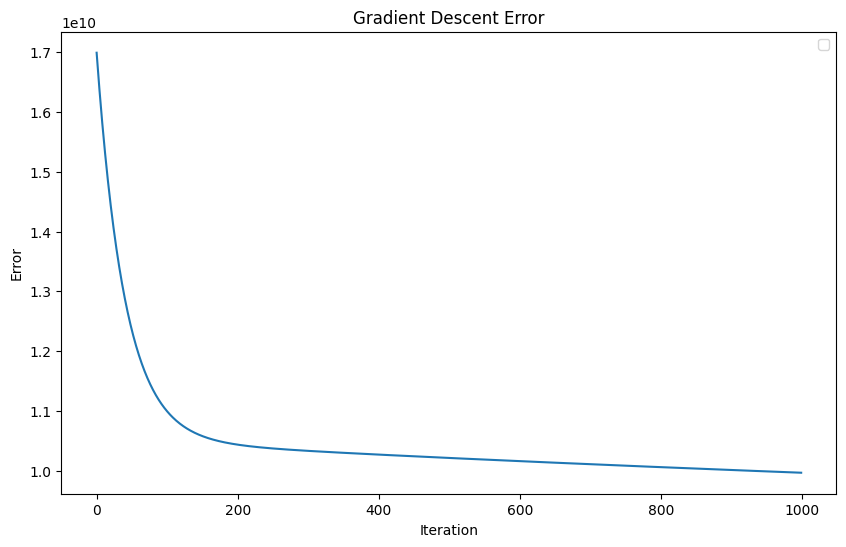

In [24]:

# Using Gradient Descent
learning_rate = 0.01
num_iterations = 1000
errors = []
W = np.random.randn(X_num.shape[1], 1) * 0.01  # Initialize W randomly
b = np.random.randn(1, 1) * 0.01  # Initialize b randomly
y_num = y_num.reshape(-1, 1)

for i in range(num_iterations):
    # compute errors
    pred = np.dot(X_num, W) + b
    difference = pred - y_num

    # compute steps
    W = W - learning_rate * np.matmul(X_num.T, difference) / X_num.shape[0]
    b = b - learning_rate * np.sum(difference) / X_num.shape[0]

    errors.append(np.mean(difference**2))
    if i % 100 == 0:
        print(f"Iteration {i}: Error = {errors[-1]}")

plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), errors)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Gradient Descent Error')
plt.legend()
plt.show()



# Comparison: Closed-Form Solution vs Gradient Descent

In [26]:
# prediction using gradient descent parameters
y_pred_gd = X_val.dot(W) + b

In [28]:
print('Score on Closed-Form Solution')
print(f"  MAE: {mean_absolute_error(y_val, y_pred_clf)}")
print(f"  MSE: {mean_squared_error(y_val, y_pred_clf)}")
print(f"  R-squared: {r2_score(y_val, y_pred_clf)}\n")


print('Score on Gradient Descent')
print(f"  MAE: {mean_absolute_error(y_val, y_pred_gd)}")
print(f"  MSE: {mean_squared_error(y_val, y_pred_gd)}")
print(f"  R-squared: {r2_score(y_val, y_pred_gd)}\n")

Score on Closed-Form Solution
  MAE: 27426.902706343
  MSE: 2537846679.962121
  R-squared: 0.5973434102891375

Score on Gradient Descent
  MAE: 38548.9357285449
  MSE: 4462588156.156118
  R-squared: 0.29196253562932806



In [29]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
models.append(model)
predictions.append(y_pred)
model_names.append("Linear Regression")



In [30]:
# Polynomial Regression
for i in range(2, 5):
    poly = PolynomialFeatures(degree=i)
    # don't use fit_transform on validation and test sets to prevent data leakage
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)
    PolyRegression = LinearRegression()
    PolyRegression.fit(X_train_poly, y_train)
    y_pred = PolyRegression.predict(X_val_poly)
    train_poly_features.append(X_train_poly)
    test_poly_features.append(X_test_poly)
    models.append(PolyRegression)
    predictions.append(y_pred)
    feature_names_list.append(poly.get_feature_names_out())
    model_names.append(f"Polynomial Regression (degree={i})")

In [31]:

# Standard Gaussian Kernel (RBF)

rbf = SVR(kernel='rbf')
rbf.fit(X_train, y_train)
y_pred = rbf.predict(X_val)
models.append(rbf)
predictions.append(y_pred)
model_names.append("RBF Kernel")

# Applying Regularization


In [32]:
# apply grid search to lasso and ridge reguralization techniques
lasso = Lasso()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_val, y_val)
lasso_regressor = lasso_regressor.best_estimator_

ridge = Ridge()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_val, y_val)
ridge_regressor = ridge_regressor.best_estimator_

# fit the best model to the training data
lasso_regressor.fit(X_train, y_train)
ridge_regressor.fit(X_train, y_train)

models.append(lasso_regressor)
models.append(ridge_regressor)
model_names.append("Lasso")
predictions.append(lasso_regressor.predict(X_val))
model_names.append("Ridge")
predictions.append(ridge_regressor.predict(X_val))



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.160e+10, tolerance: 5.075e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.647e+10, tolerance: 6.653e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.610e+11, tolerance: 6.745e

# Model Evaluation

In [33]:

scores = {'MAE': [], 'MSE': [], 'R_squared': []}

for i in range(len(predictions)):
    scores['MAE'].append(mean_absolute_error(y_val, predictions[i]))
    scores['MSE'].append(mean_squared_error(y_val, predictions[i]))
    scores['R_squared'].append(r2_score(y_val, predictions[i]))

# Print the scores
print("Scores:")
for i in range(len(predictions)):
    print(f"{model_names[i]}:")
    print(f"  MAE: {scores['MAE'][i]}")
    print(f"  MSE: {scores['MSE'][i]}")
    print(f"  R-squared: {scores['R_squared'][i]}\n")

best_model_index = scores['R_squared'].index(max(scores['R_squared']))
best_model = models[best_model_index]
print(f"The best model is {model_names[best_model_index]} with R-squared = {scores['R_squared'][best_model_index]}")







Scores:
Linear Regression:
  MAE: 27426.9281726817
  MSE: 2537847086.921872
  R-squared: 0.5973433457206091

Polynomial Regression (degree=2):
  MAE: 35159.996418277115
  MSE: 4042507118.390758
  R-squared: 0.3586128968999013

Polynomial Regression (degree=3):
  MAE: 24769.073839316537
  MSE: 5742758300.878278
  R-squared: 0.08884981459955343

Polynomial Regression (degree=4):
  MAE: 58272.170475972576
  MSE: 1066351983954.8091
  R-squared: -168.18817700093072

RBF Kernel:
  MAE: 42581.18789358323
  MSE: 6966109997.856401
  R-squared: -0.10524805041787144

Lasso:
  MAE: 27350.862312789694
  MSE: 2534287863.504075
  R-squared: 0.5979080546822437

Ridge:
  MAE: 27310.35419101763
  MSE: 2530363121.4601016
  R-squared: 0.5985307570934646

The best model is Ridge with R-squared = 0.5985307570934646


In [34]:
#Function of mean squared error
def neg_mse(y_true, y_pred):
    squared_errors = (y_true - y_pred) ** 2  # Calculate squared errors
    mse = np.mean(squared_errors)  # Calculate the mean of squared errors
    return mse*-1  # Return the MSE

In [35]:

def feature_selection(dataset, model, poly, degree=2): # Added degree parameter
    """
    Selects the best features based on MSE after applying polynomial regression.

    Args:
        dataset (pd.DataFrame): The entire dataset with features and target.
        model: The model to use for evaluation.
        degree (int, optional): The degree of the polynomial features. Defaults to 2.

    Returns:
        list: A list of the selected feature names.
        pd.DataFrame: The training data with selected features.
        pd.DataFrame: The test data with selected features.
    """

    x = dataset.drop(['price'], axis=1)
    y = dataset['price']

    if poly == True:
      # Apply PolynomialFeatures
      poly_features = PolynomialFeatures(degree=degree)
      x_poly = poly_features.fit_transform(x)
      feature_names = poly_features.get_feature_names_out(input_features=x.columns)
      x = pd.DataFrame(x_poly, columns=feature_names, index=x.index) # Keep original index


    # Split data after polynomial transformation
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=58)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=58)


    lreg = model  # Used in this function.

    allFeatures = list(X_train.columns)
    mseList = []  # To know what is the best feature.
    mse2 = []  # This carries feature names, with the same index as the first one.
    bestChoice = []  # Best features were chosen. To use them in the next iterations.
    mseForComper = []

    for i in range(0, X_train.shape[1]):  # Iterating all features...
        for feature in allFeatures:  # Iterating all features.
            lreg.fit(X_train[bestChoice + [feature]].values, y_train)
            y_pred = lreg.predict(X_val[bestChoice + [feature]].values)

            mse = neg_mse(y_val, y_pred)
            mseList.append(mse)
            mse2.append(feature)

        mseForComper.append(max(mseList))

        if len(mseForComper) >= 2:  # If there is more than one element, check if the mse is getting bigger, if true --> stop with the best features included.
            if mseForComper[-1] < mseForComper[-2]:
                break

        bestChoice.append(mse2[mseList.index(max(mseList))])
        mseList.clear()
        mse2.clear()

        allFeatures.remove(bestChoice[-1])

    # Return selected features and transformed data
    return bestChoice, X_train[bestChoice], X_test[bestChoice]

# Call feature_selection with the entire dataset
poly = 1 < best_model_index and best_model_index < 5
best_features, X_train_selected, X_test_selected = feature_selection(pf, best_model, best_model_index)

# ... (Continue with your model training and evaluation) ...

In [43]:
# print the best features
print('Original Features:')
print(X_train.columns)
best_features

Original Features:
Index(['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats',
       'brand', 'country_bahrain', 'country_egypt', 'country_ksa',
       'country_kuwait', 'country_oman', 'country_qatar', 'country_uae'],
      dtype='object')


['horse_power',
 'top_speed',
 'cylinder',
 'engine_capacity',
 'brand',
 'country_ksa',
 'seats',
 'country_kuwait',
 'country_bahrain',
 'country_egypt']

#Evaluation on the Test Set

In [36]:
best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)

print(f"{model_names[best_model_index]}:")
print(f"  MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"  MSE: {mean_squared_error(y_test, y_pred)}")
print(f"  R-squared: {r2_score(y_test, y_pred)}\n")

Ridge:
  MAE: 28189.572265402214
  MSE: 4644177544.61307
  R-squared: 0.4682906029810352



#Reporting Results

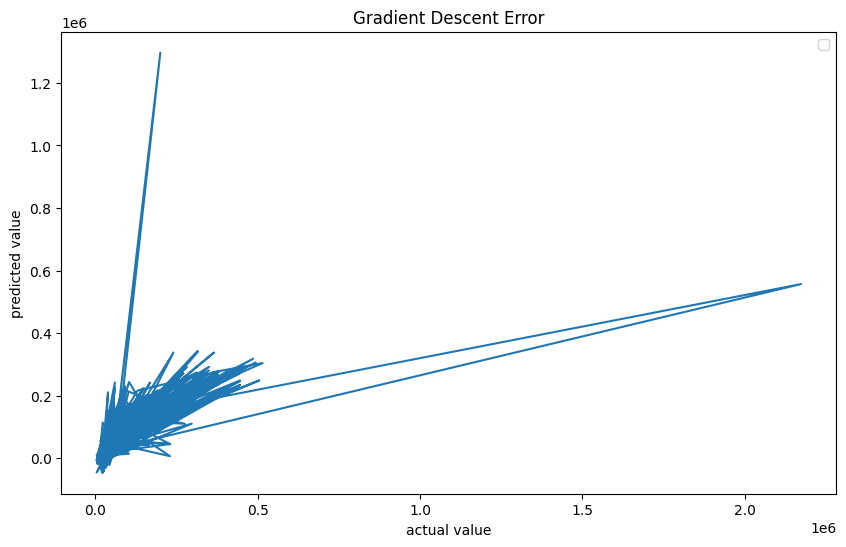

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_pred)
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.title('Gradient Descent Error')
plt.legend()
plt.show()

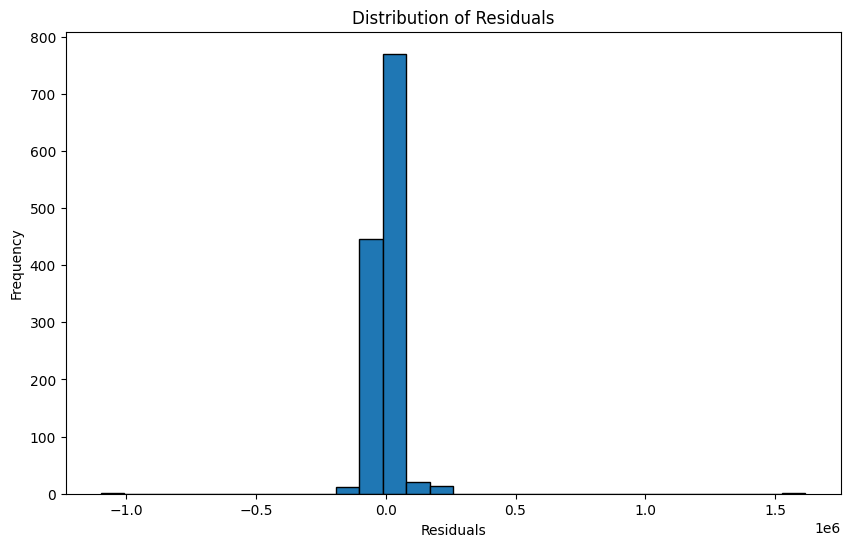

In [44]:
# error distribution
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()


In [38]:
# 3. Get feature importances (absolute values of coefficients)
feature_importances = np.abs(best_model.coef_)

# 4. Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train_selected.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 5. Print or visualize the feature importances
print(feature_importance_df)

           Feature    Importance
0      horse_power  1.154432e+06
1        top_speed  3.955198e+05
2         cylinder  2.069318e+05
6            seats  7.361707e+04
3  engine_capacity  1.564085e+04
5      country_ksa  1.224615e+04
4            brand  8.860445e+03
9    country_egypt  2.245005e+03
7   country_kuwait  2.050590e+03
8  country_bahrain  5.277851e+02


# Optional Part

In [47]:

# 1. Choose a new target variable
new_target = 'top_speed'  # Replace with the actual column name from your dataset

# 2. Prepare the data
pf['top_speed'] = optional_target # since it's normalized
X = pf.drop([new_target], axis=1) # Drop the old and the new target columns to avoid data leakage
y = pf[new_target]

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58)

# 4. Train the best model on the new target
best_model.fit(X_train, y_train) # Assuming best_model is already defined and trained

# 5. Evaluate the model
y_pred = best_model.predict(X_test)


# print scores of the model
print(f"  MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"  MSE: {mean_squared_error(y_test, y_pred)}")
print(f"  R-squared: {r2_score(y_test, y_pred)}")

  MAE: 22.433144170461972
  MSE: 1365.8405969069536
  R-squared: 0.4026999134040282
